In [1]:
# Setup dependencies (as taken from assignment 6)
import os
import math
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from joblib import load

from pytorch_forecasting.metrics import QuantileLoss

#Additional Setup to use Tensorboard
!pip install -q tensorflow
%load_ext tensorboard

In [2]:
dayahead_scaler = load('dayahead_scaler.bin')

In [3]:
df = pd.read_csv('day_ahead.csv')
df = df.set_index('datetime')
df.index = pd.to_datetime(df.index)
# df=df["Day-ahead Price [EUR/MWh]"].to_frame()
df

,Day-ahead Price [EUR/MWh],tempC,windspeedKmph,winddirDegree,precipMM,humidity,pressure,time_increment
datetime,,,,,,,,
2015-01-05 00:00:00,-0.243620,-1.722376,-0.422598,0.563889,0.000000,0.96,2.163731,2.4
2015-01-05 01:00:00,-0.316395,-1.722376,-0.297098,0.572222,0.000000,0.96,2.058525,0.1
2015-01-05 02:00:00,-0.439933,-1.722376,-0.171598,0.580556,0.000000,0.96,2.058525,0.2
2015-01-05 03:00:00,-0.625914,-1.722376,-0.046098,0.588889,0.000000,0.96,1.953318,0.3
2015-01-05 04:00:00,-0.626363,-1.722376,-0.171598,0.575000,0.000000,0.96,1.953318,0.4
...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,0.877205,-1.130468,-0.673599,0.602778,0.054545,0.94,-1.728907,1.9
2020-12-31 20:00:00,0.665169,-1.130468,-0.422598,0.625000,0.036364,0.93,-1.728907,2.0
2020-12-31 21:00:00,0.469755,-1.130468,-0.171598,0.650000,0.054545,0.93,-1.623701,2.1


# Create Torch dataset

In [4]:
# sequence length (edit the value for different sequence length)
seq = 24 

In [5]:
delta = pd.Timedelta(seq, unit ='h')
# define 1 hour object for convenience when using datetime as index in the dataframe to not include the last item
hours_12 = pd.Timedelta(12, unit ='h') # used mostly for empty 12 hours 
hour = pd.Timedelta(1, unit ='h')
day = pd.Timedelta(1, unit ='d')

In [6]:
### creating training dataset
train_y_start = dt.datetime(2015, 1, 5, 0, 0) + (delta+hours_12).ceil('1d')
#train_x_start = train_y_start - delta - hours_12
train_end = dt.datetime(2020, 10, 31, 23, 0)

train_x = []
train_y = []
while train_y_start + day - hour <= train_end:
    train_x_start = train_y_start - delta - hours_12
    
    
    #print(train_x_start, train_y_start)
    train_x.append(df[train_x_start:train_x_start+delta - hour].values)
    train_y.append(df[train_y_start:train_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)
    
    train_y_start += day
    
train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
print(train_x.shape)
print(train_y.shape)
# print(train_x)
# print(train_y)

(2125, 24, 8)
(2125, 24)


In [7]:
### creating validation dataset
val_y_start = dt.datetime(2020, 11, 1, 0, 0)
val_end = dt.datetime(2020, 11, 30, 23, 0)

val_x = []
val_y = []
while val_y_start + day - hour <= val_end:
    val_x_start = val_y_start - delta - hours_12
    
    val_x.append(df[val_x_start:val_x_start+delta - hour].values)
    val_y.append(df[val_y_start:val_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)
    
    val_y_start += day

val_x = np.asarray(val_x)
val_y = np.asarray(val_y)
print(val_x.shape)
print(val_y.shape)

(30, 24, 8)
(30, 24)


In [8]:
### creating testing dataset
test_y_start = dt.datetime(2020, 12, 1, 0, 0)
test_end = dt.datetime(2020, 12, 31, 23, 0)

test_x = []
test_y = []
while test_y_start + day - hour <= test_end:
    test_x_start = test_y_start - delta - hours_12
    
    test_x.append(df[test_x_start:test_x_start+delta - hour].values)
    test_y.append(df[test_y_start:test_y_start+day - hour]['Day-ahead Price [EUR/MWh]'].values)
    
    test_y_start += day

test_x = np.asarray(test_x)
test_y = np.asarray(test_y)
print(test_x.shape)
print(test_y.shape)

(31, 24, 8)
(31, 24)


In [9]:
# create tensor objects
x_train = torch.from_numpy(train_x).float()
y_train = torch.from_numpy(train_y).float()
x_val = torch.from_numpy(val_x).float()
y_val = torch.from_numpy(val_y).float()
x_test = torch.from_numpy(test_x).float()
y_test = torch.from_numpy(test_y).float()
# train_loader = DataLoader(x_train,y_train, batch_size=128, shuffle=False)
# val_loader = DataLoader(x_test,y_test batch_size=128, shuffle=True)

# Define BLSTM model

In [60]:
class BLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, quantiles):
        super(BLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim*2, output_dim) # multiply hidden_dim by 2 because bidirectional
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        self.out_shape = len(quantiles)
        
        final_layers = [
            nn.Linear(hidden_dim*2, output_dim) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def add_noise_to_weights(self):
        with torch.no_grad():
            # add noise to lstm weights
            for weights in model.lstm._all_weights:
                for weight in weights:
                    noise = torch.normal(0, 0.01, size=self.lstm._parameters[weight].size())
                    self.lstm._parameters[weight].add_(noise)
            # add noise to linear layer weights, most likely unnecessary
#             for layer in self.final_layers:
#                 if hasattr(layer, 'weight'):
#                     noise = torch.normal(0, 0.05, size=layer.weight.size())
#                     layer.weight.add_(noise)

        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() #hidden layer output
        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).requires_grad_() 
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Index hidden state of last time step
#         _out = self.fc(out[:, -1, :])
        
        return torch.stack([layer(out[:, -1, :]) for layer in self.final_layers], dim=1)
        
        
#         return out

## Training

In [64]:
num_train = x_train.shape[0]
input_dim = x_train.shape[2]
output_dim = 24 
hidden_dim = 10 # no. of neurons in hidden layer
num_layers = 2 # no of hidden layers 
num_epochs = 100

In [65]:
quantiles = [.01,0.05, 0.10,0.25, .5, 0.75, 0.90, 0.95, .99]
criterion = QuantileLoss(quantiles)

model = BLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, quantiles=quantiles)
# for practice use MSE, in real experiment use NLLLOSS for parametric
print(model)

#criterion = nn.NLLLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

BLSTM(
  (lstm): LSTM(8, 10, num_layers=2, batch_first=True, bidirectional=True)
  (final_layers): ModuleList(
    (0): Linear(in_features=20, out_features=24, bias=True)
    (1): Linear(in_features=20, out_features=24, bias=True)
    (2): Linear(in_features=20, out_features=24, bias=True)
    (3): Linear(in_features=20, out_features=24, bias=True)
    (4): Linear(in_features=20, out_features=24, bias=True)
    (5): Linear(in_features=20, out_features=24, bias=True)
    (6): Linear(in_features=20, out_features=24, bias=True)
    (7): Linear(in_features=20, out_features=24, bias=True)
    (8): Linear(in_features=20, out_features=24, bias=True)
  )
)


In [66]:
# Patience - how many epochs to keep training after accuracy has not improved
patience = 5

# Initialize early stopping variables
val_loss_best = np.Inf
patience_cnt = 0

# training loop
val_losses = []
for t in range(num_epochs): 
    err = 0
    for i in range(num_train):
        model.add_noise_to_weights() # adding noise to lstm weights during the training
        y_train_pred = model(x_train[i].unsqueeze(0))

        loss = torch.mean(torch.sum(criterion.loss(torch.transpose(y_train_pred,1,2), y_train[i]), dim=2))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        err += loss.item()
        
    with torch.no_grad():
        preds=model(x_val)
        val_loss = torch.mean(torch.sum(criterion.loss(torch.transpose(preds,1,2), y_val), dim=2)).item()
        val_losses.append(val_loss)
    
    print("Epoch ", t+1, "training loss: ", err/num_train, "validation loss: ", val_loss)
    
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        patience_cnt = 0
    else:
        patience_cnt +=1
        if patience_cnt == patience:
            print("Early stopping")
            break
 

Epoch  1 training loss:  0.9636192497646108 validation loss:  0.8346549272537231
Epoch  2 training loss:  0.9244497227809009 validation loss:  0.8262961506843567
Epoch  3 training loss:  0.9006396905674654 validation loss:  0.8178761005401611
Epoch  4 training loss:  0.8909461239926956 validation loss:  0.8041594624519348
Epoch  5 training loss:  0.8909279234970318 validation loss:  0.791286826133728
Epoch  6 training loss:  0.8832045979359571 validation loss:  0.8540537357330322
Epoch  7 training loss:  0.8819951967632069 validation loss:  0.8032194972038269
Epoch  8 training loss:  0.8777909570020788 validation loss:  0.7955278754234314
Epoch  9 training loss:  0.874993094850989 validation loss:  0.8108619451522827
Epoch  10 training loss:  0.8718469272501328 validation loss:  0.8154060244560242
Early stopping


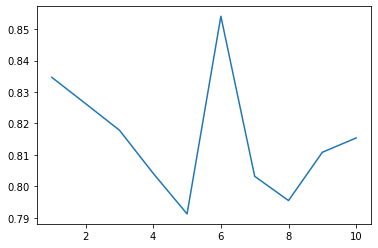

In [67]:
X = np.arange(1, len(val_losses)+1)
plt.plot(X, val_losses)
plt.show()

In [68]:
# Make the prediction on the meshed x-axis
model.eval()
with torch.no_grad():
    preds=model(x_test)

In [69]:
preds = dayahead_scaler.inverse_transform(preds)

In [70]:
test_df = df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 31, 23, 0)][['Day-ahead Price [EUR/MWh]']]
test_df[test_df.columns] = dayahead_scaler.inverse_transform(test_df.values)
for i in range(preds.shape[1]):
    y=preds[:,i,:]
    test_df[str(i)]=y.flatten()

In [88]:
preds_test = torch.from_numpy(np.transpose(preds,(0,2,1)))
y_test_price = torch.from_numpy(test_df['Day-ahead Price [EUR/MWh]'].values.reshape((-1, 24)))

# quantile loss in term of dayahead price (not normalize or standardize)
torch.mean(torch.sum(criterion.loss(preds_test, y_test_price), dim=2)).item()

24.715593681598495

In [ ]:
#test_df.plot()    

# y_lower, y_pred, y_upper = preds[:, 0,:], preds[:, 1,:], preds[:, 2,:],
# print(y_lower.shape)


# test_df['q1'] = y_lower.flatten()
# test_df['q2'] = y_pred.flatten()
# test_df['q3'] = y_upper.flatten()
# test_df.plot();


# Plot the function, the prediction and the 90% confidence interval based on
# # the MSE
# fig = plt.figure()
# plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
# plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
# plt.plot(xx, y_pred, 'r-', label=u'Prediction')
# plt.plot(xx, y_upper, 'k-')
# plt.plot(xx, y_lower, 'k-')
# plt.fill(np.concatenate([xx, xx[::-1]]),
#          np.concatenate([y_upper, y_lower[::-1]]),
#          alpha=.5, fc='b', ec='None', label='90% prediction interval')
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')
# plt.ylim(-10, 20)
# plt.legend(loc='upper left')
# plt.show()

In [ ]:
# plot whole data

fig = plt.figure(figsize=(20,10))
plt.plot(test_df.index, test_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['8'].values.flatten(), test_df['0'].values.flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['7'].values.flatten(), test_df['1'].values.flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['6'].values.flatten(), test_df['2'].values.flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([test_df.index, test_df.index[::-1]]),
         np.concatenate([test_df['5'].values.flatten(), test_df['3'].values.flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('Date')
plt.ylabel('Day ahead Price')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# plot first 7 days

part_df = test_df[dt.datetime(2020, 12, 1, 0, 0):dt.datetime(2020, 12, 8, 0, 0)]
part_df

fig = plt.figure(figsize=(20,10))
plt.plot(part_df.index, part_df['Day-ahead Price [EUR/MWh]'].values, 'r', label='expected')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['8'].values.flatten(), part_df['0'].values.flatten()]),
         alpha=.25, fc='grey', ec='None', label='98% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['7'].values.flatten(), part_df['1'].values.flatten()]),
         alpha=.5, fc='grey', ec='None', label='90% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['6'].values.flatten(), part_df['2'].values.flatten()]),
         alpha=.75, fc='grey', ec='None', label='80% prediction interval')

plt.fill(np.concatenate([part_df.index, part_df.index[::-1]]),
         np.concatenate([part_df['5'].values.flatten(), part_df['3'].values.flatten()]),
         alpha=0.9, fc='grey', ec='None', label='50% prediction interval')

plt.xlabel('Date')
plt.ylabel('Day ahead Price')
plt.legend(loc='upper right')
plt.show()